# Assignment 6: Reduction of dimensionality and recognition

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from a6_utils import *
import cv2 as cv2
from UZ_utils import *

## Exercise 1: Direct PCA method

The primary purpose of the PCA method is reduction of dimensionality. This means that
we want to find such a linear transformation of the input data that will describe the data
in a low dimensional orthogonal space (which can also be called a subspace) while losing
the minimal amount of information needed to reconstruct the data. A subspace is defined
by its basis vectors.

### A)
Solve the following assignment by hand for practice: You are given four points
A(3; 4), B(3; 6), C(7; 6) and D(6; 4). Calculate the eigenvectors and eigenvalues for
the given set of points.

In [1]:
import numpy as np
A = [[3,4],
[3,6],
[7,6],
[6,4]]

A = np.array(A)

U,v,d = np.linalg.svd(A)

print(U)
print(v)
print(d)


[[-0.35056636 -0.25351332 -0.68622263 -0.58475015]
 [-0.45095167 -0.76860929  0.14916864  0.42852196]
 [-0.65067933  0.26696221  0.581828   -0.40844065]
 [-0.5003621   0.5231653  -0.41027235  0.55462819]]
[14.12449298  2.73837505]
[[-0.70526298 -0.70894579]
 [ 0.70894579 -0.70526298]]


### B)
Write a script to calculate and visualize PCA from 2D data from the file points.txt
(the first column contains the x axis and the second column the y axis). Plot the
points and draw the representation of the Gaussian distribution using drawEllipse
from the supplementary material. Follow the Algorithm 1 to compute the eigenvectors
and eigenvalues of the PCA subspace

[[5.84 1.8 ]
 [1.8  2.  ]]


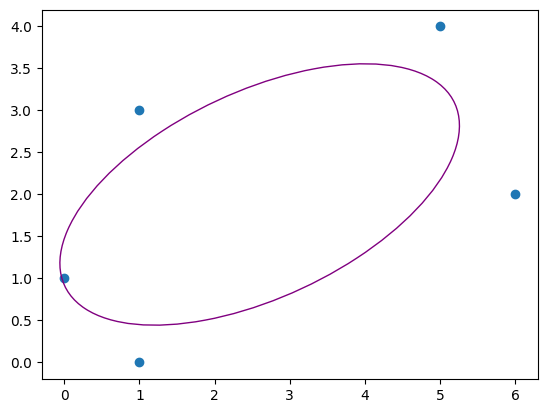

[6.55180546 1.28819454]
[[ 0.92992935 -0.36773822]
 [ 0.36773822  0.92992935]]


In [56]:
points = np.loadtxt("./data/points.txt")
points = points.T
plt.scatter(points[0,:], points[1,:])
mean = np.mean(points, axis=1)
points = points - mean[:, np.newaxis]
cov2 = (1/5) * (points @ points.T)
print(cov2)
drawEllipse(mean, cov2, n_std=1.1)
plt.show()

## get eigenvector and values from cov2
eig_val, eig_vec = np.linalg.eig(cov2)
print(eig_val)
print(eig_vec)

# [[5.84 1.8 ]
#  [1.8  2.  ]]


## Exercise 2: The dual PCA method

When analyzing image data, the dimensionality can become very large (much larger than
the number of elements in the input), the direct method of computing eigenvectors we
used previously is no longer suitable. E.g. if we have 10000-dimensional data, this would
produce a covariance matrix of size 1000010000. Here we are close to hitting the limits of
computer memory. As the number of data samples N is lower than the dimensionality we
can use the dual PCA method.

## Exercise 3: Image decomposition examples

Here we will use the dual PCA method on a computer vision problem. In the supplementary
material there are three series of images. Each series contains 64 images of a face
under different lighting conditions. Your task will be to analyze each series using the PCA
method.